This module utilizes the following dataset:
https://www.kaggle.com/datasets/undefinenull/million-song-dataset-spotify-lastfm

It can either be imported using the code block below or downloaded manually as a .zip file. If you use the code below, make sure to run `pip install kagglehub` first.

Almost all code here was generated using AI, but it was a collaborative process
and required a TON of debugging.

In [58]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("undefinenull/million-song-dataset-spotify-lastfm")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\yalts\.cache\kagglehub\datasets\undefinenull\million-song-dataset-spotify-lastfm\versions\1


### Go to the specified path above and copy 'Music Info.csv' from that folder to the same directory as this Python file. Then, rename 'Music Info.csv' to 'music.csv'.

In [49]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

In [ ]:
# Load the dataset
music_df = pd.read_csv('music.csv')

# Clean the tags column
music_df['tags'] = music_df['tags'].astype(str).str.lower().str.strip()

# Split tags into lists
music_df['tag_list'] = music_df['tags'].str.split(', ')

# Drop rows with missing values in key columns.  Important for subsequent steps.
music_df = music_df.dropna(subset=['artist', 'tag_list'])
drop_conditions = music_df[(music_df['tag_list'] == '[nan]') | (music_df['tags'] == 'nan')].index #line above wasn't sufficient, grabbed and modified code from geeksforgeeks.org
music_df.drop(drop_conditions, inplace=True)

# --- Feature Extraction and Transformation ---
# 1. Convert tag lists to strings for TF-IDF Vectorizer
music_df['tag_string'] = music_df['tag_list'].apply(lambda x: ' '.join(x))

# 2. Apply TF-IDF Vectorizer
#    - Converts text documents (tag strings) into a matrix of TF-IDF features.
#    - TF-IDF helps to weight tags by their importance.
vectorizer = TfidfVectorizer()
tag_tfidf = vectorizer.fit_transform(music_df['tag_string'])

# 3. Normalize the TF-IDF matrix
#    - Normalization ensures that each artist's tag vector has a unit norm.
#    - This is important for distance-based clustering algorithms like KMeans.
tag_tfidf_normalized = normalize(tag_tfidf)

# Convert the normalized TF-IDF matrix to a Pandas DataFrame
tag_df = pd.DataFrame(tag_tfidf_normalized.toarray(), index=music_df['artist'])

tag_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
artist,,,,,,,,,,,,,,,,,,,,,
The Killers,0.525007,0.0,0.0,0.0,0.000000,0.0,0.372116,0.422640,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Oasis,0.000000,0.0,0.0,0.0,0.376043,0.0,0.279198,0.317106,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nirvana,0.000000,0.0,0.0,0.0,0.505319,0.0,0.375181,0.426121,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Franz Ferdinand,0.423279,0.0,0.0,0.0,0.000000,0.0,0.300012,0.340747,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Radiohead,0.000000,0.0,0.0,0.0,0.407326,0.0,0.302424,0.343486,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Maximilian Hecker,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fact,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.631100,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACIDMAN,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.403241,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# --- Clustering with Tags Only ---
# Use tag_df directly for clustering.  No scaling is needed for this binary data.
# 1. Determine Optimal k using Silhouette Score and Elbow Method
#    - Silhouette Score: Measures how well each data point fits within its cluster.
#    - Elbow Method:  Plots the within-cluster sum of squares (WCSS) for different
#      values of k.  The "elbow" in the plot suggests a good value for k.
range_n_clusters = range(2, 51)  # You can adjust this range as needed.
silhouette_scores = []
wcss = []  # Within-cluster sum of squares

for n_clusters in range_n_clusters:
    # Initialize KMeans with the current number of clusters
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    # Fit KMeans to the tag data
    cluster_labels = clusterer.fit_predict(tag_df)
    # Calculate the Silhouette Score
    # silhouette_avg = silhouette_score(tag_df, cluster_labels)
    # silhouette_scores.append(silhouette_avg)
    # Calculate WCSS (Elbow Method)
    wcss.append(clusterer.inertia_)
    # print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg:.4f}")

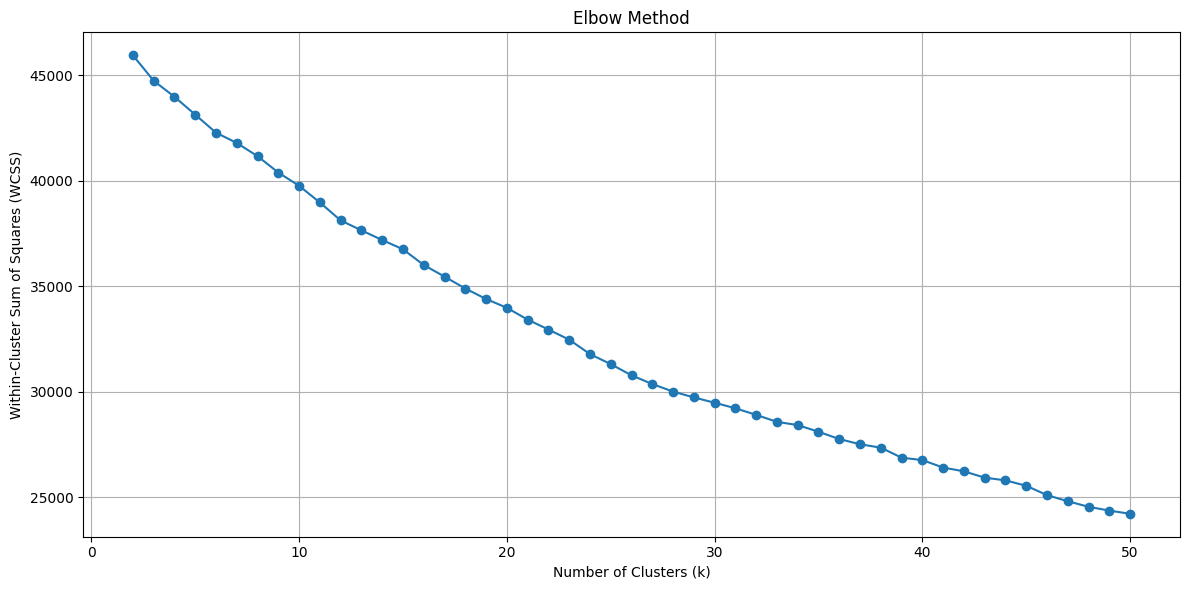

The optimal number of clusters (k) based on Elbow Method is: 12


In [64]:
# # Plot the Silhouette Scores
plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(range_n_clusters, silhouette_scores, marker='o')
# plt.title('Silhouette Score vs. Number of Clusters')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.grid(True)

# Plot the Elbow Method
# plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# # Determine the optimal k based on the highest Silhouette Score
# optimal_k_silhouette = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
# print(f"\nThe optimal number of clusters (k) based on Silhouette Score is: {optimal_k_silhouette}")

# Determine the optimal k by finding the elbow in the WCSS plot
optimal_k_elbow = 12 #int(input("Where is the elbow located? RECOMMENDED INPUT: 12")) # <-- Hardcoded, I determined the best K was 12 based on the elbow method below.
# Silhouette score straight-up nearly crashed my computer, so it's not worth it tbh.
print(f"The optimal number of clusters (k) based on Elbow Method is: {optimal_k_elbow}")


In [53]:
# 2. Apply KMeans clustering with the optimal k
optimal_k = optimal_k_elbow # Change to optimal_k_silhouette if you want
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(tag_df)
final_df = pd.DataFrame(tag_df.index, columns=['artist'])  # Start with artist names
final_df['cluster'] = kmeans_labels  # Add cluster labels

print("\nFinal DataFrame with Cluster Labels (Tags Only):")
print(final_df.head())

# 3. Visualize Clusters using t-SNE
#    Apply t-SNE to the tag data.
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(tag_df)

# Create a DataFrame for the t-SNE results and cluster labels
tsne_df = pd.DataFrame({'tsne_1': tsne_results[:, 0], 'tsne_2': tsne_results[:, 1], 'cluster': final_df['cluster']})

final_df = final_df.merge(music_df[['artist', 'tag_list']], on='artist', how='left') #added tag_list back to the final df


Final DataFrame with Cluster Labels (Tags Only):
            artist  cluster
0      The Killers        7
1            Oasis        7
2          Nirvana        7
3  Franz Ferdinand        7
4        Radiohead        7


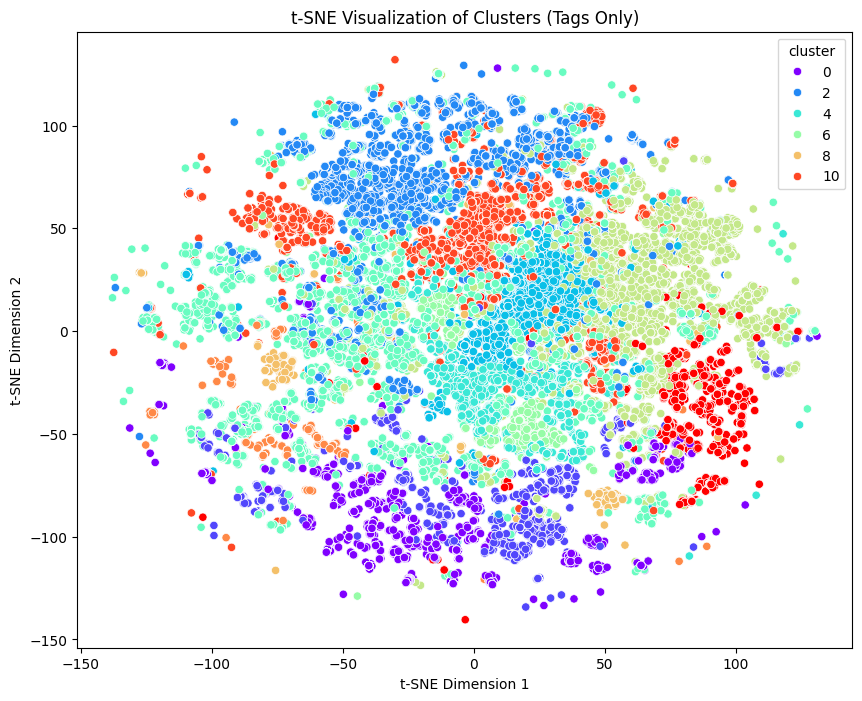

In [54]:
# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster', palette='rainbow', data=tsne_df)
plt.title('t-SNE Visualization of Clusters (Tags Only)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [55]:
# 4. Genre Heatmap
#  Extract genre information as before
def extract_genre(tag_list):
    if isinstance(tag_list, list):
        return tag_list  # Return the entire list of tags
    else:
        return ['Unknown']  # Return a list with 'Unknown' for consistency

final_df['genre'] = final_df['tag_list'].apply(extract_genre) #changed to use the tag_list column from the merged dataframe

# Create a contingency table (cross-tabulation) of clusters and genres.
#  This part needs to be adapted, as the 'genre' column now contains lists.
#  We'll create a table that shows the count of each genre within each cluster.

def create_cluster_genre_table(df):
    cluster_genre_dict = defaultdict(lambda: defaultdict(int))
    for _, row in df.iterrows():
        cluster = row['cluster']
        for genre in row['genre']:
            cluster_genre_dict[cluster][genre] += 1
    return pd.DataFrame(cluster_genre_dict).fillna(0).astype(int)

cluster_genre_table = create_cluster_genre_table(final_df)


# Normalize the contingency table
cluster_genre_normalized = cluster_genre_table.div(cluster_genre_table.sum(axis=1), axis=0)

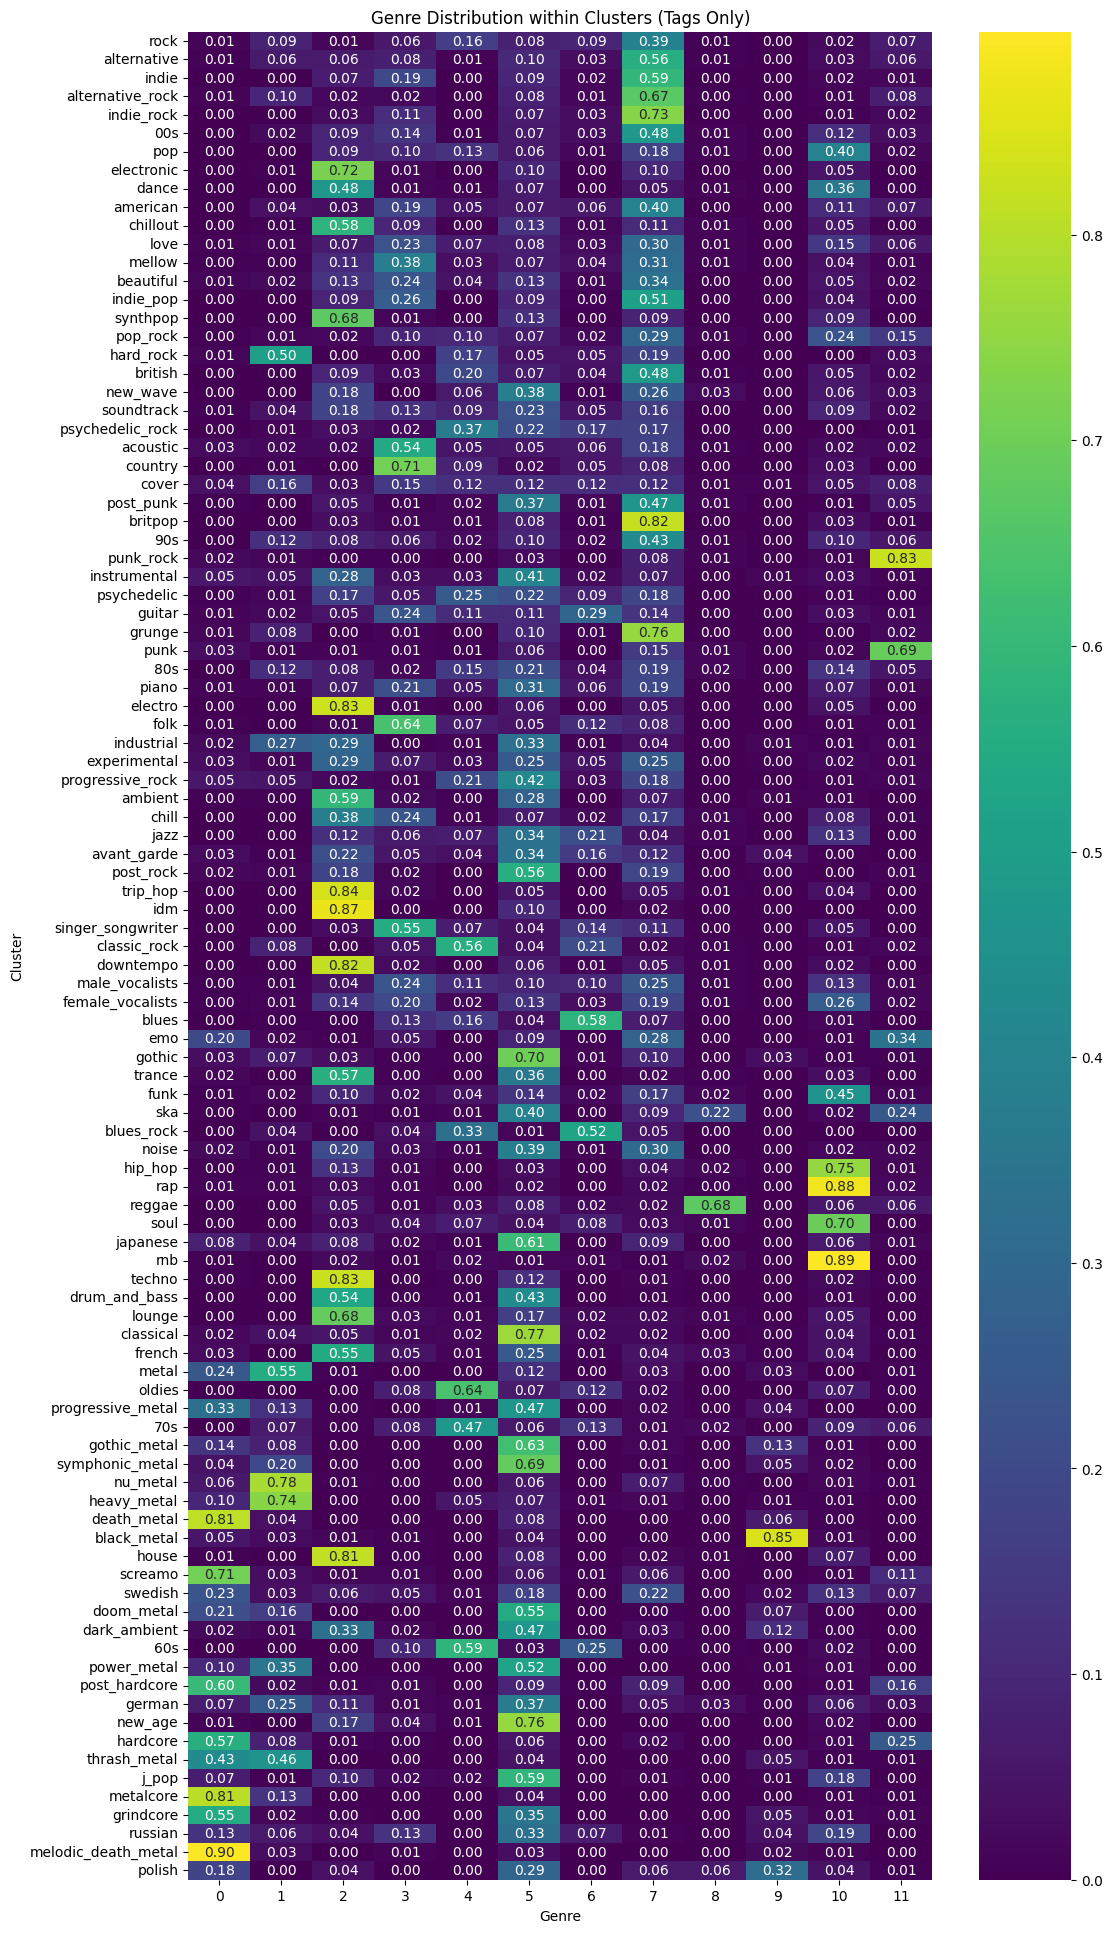

In [56]:
# Get the list of genres from the columns of the normalized table
sorted_genres = cluster_genre_normalized.columns.tolist()
sorted_genres.sort()  # Sort the genres alphabetically

# Plot the heatmap.
plt.figure(figsize=(12, 24))
sns.heatmap(cluster_genre_normalized[sorted_genres], annot=True, cmap='viridis', fmt='.2f') # Pass sorted genres to heatmap
plt.title('Genre Distribution within Clusters (Tags Only)')
plt.xlabel('Genre')
plt.ylabel('Cluster')
plt.show()
# --- End Genre Heatmap ---

The different clusters have different features:

0. **Heavy metal and variants** (death metal, melodic death metal, death metal, hardcore, thrash metal, screamo)
1. **Hardcore metal is too much for me plz and thank you** (metal, nu metal, grunge, hard rock and alternative rock)
2. **Electronic Music** (electronic, dance, synthpop, electro, house, techno,
                        drum & bass, trance, idm)
3. **Country/Acoustic/Folk**
4. **Older music** (60s, 70s, oldies, blues, classic rock, psychedelic rock)
5. **"I'm not like the other guys" 🤘🧐** (new age, gothic metal, doom metal, symphonic metal, instrumental, classical, gothic)
6. **Blues and Blues Rock**
7. **British and Indie** (british pop, indie, indie pop, indie rock)
8. **Reggae and Ska**
9. **Black Metal**
10. **Pop and African American music** (soul, hip-hop, funk, rap, and pop)
11. **Punk and Punk Rock**

In [66]:
# --- Display Artists from Each Cluster ---
print("\nTwo Artists from Each Cluster:")
cluster_artists = final_df.groupby('cluster')['artist'].unique()
for cluster, artists in cluster_artists.items():
    print(f"Cluster {cluster}:")
    if len(artists) > 1:
        print(f"  - {artists[0]}")
        print(f"  - {artists[1]}")
    elif len(artists) == 1:
        print(f"  - {artists[0]}")
    else:
        print("  - No artists in this cluster")
# --- End Display ---


Two Artists from Each Cluster:
Cluster 0:
  - Bullet for My Valentine
  - Bring Me the Horizon
Cluster 1:
  - System of a Down
  - Linkin Park
Cluster 2:
  - Depeche Mode
  - Radiohead
Cluster 3:
  - Johnny Cash
  - Jack Johnson
Cluster 4:
  - Queen
  - Led Zeppelin
Cluster 5:
  - Joy Division
  - Tool
Cluster 6:
  - Jimi Hendrix
  - Cream
Cluster 7:
  - The Killers
  - Oasis
Cluster 8:
  - Sublime
  - 311
Cluster 9:
  - Finntroll
  - Burzum
Cluster 10:
  - Katy Perry
  - Michael Jackson
Cluster 11:
  - Green Day
  - The Offspring
